<a href="https://colab.research.google.com/github/WolfPitToad/SpriteGANPokemonGenerator/blob/main/SpritePokeGANV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import torch

In [340]:
#Obtener y mover datos a cuda/gpu
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [443]:
#Mover Dataloader a cuda/gpu
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [3]:
device = get_default_device()
print(device)

cuda


In [4]:
#Instalamos Kaggle para exportar las bases de datos
!pip install -q kaggle

In [5]:
!rm -rf ~/.kaggle

In [6]:
#Similar a github, Kaggle nos pide una llave para ingresar esta se descarga en un ARCHIVO llamado kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"w0lfpitt0ad","key":"d012a6f621254bab49bcc53c4e63b5ad"}'}

In [15]:
#Creamos una nueva carpeta 
!mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
#Copiamos la llave y la ocultamos para evitar sea visible
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [438]:
#Generamos carpetas en Drive para guardar resultados
project_name = "SpritePokeGAN"

NEW_DRIVE_FOLDER="/content/drive/MyDrive"
DATASET_ROOT = "/content/drive/MyDrive/Pokemon/pokemon_images"
CHECKPOINT_ROOT = f"/content/drive/MyDrive/Pokemon/checkpoints/{project_name}"
TEST_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/test_results/{project_name}"
GEN_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/gen_results/{project_name}"

import os
os.makedirs(NEW_DRIVE_FOLDER, exist_ok=True)
os.makedirs(DATASET_ROOT, exist_ok=True)
os.makedirs(CHECKPOINT_ROOT, exist_ok=True)
os.makedirs(TEST_RESULTS_ROOT, exist_ok=True)
os.makedirs(GEN_RESULTS_ROOT, exist_ok=True)

In [7]:
#Copiamos el codigo AVI del dataset para descargarlo en drive
%cd /content/drive/MyDrive/Pokemon/pokemon_images
! kaggle datasets download -d yehongjiang/pokemon-sprites-images

/content/drive/MyDrive/Pokemon/pokemon_images
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
#Descomprimimos el archivo .zip drive no recomendado t>10 min
!unzip  /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip

unzip:  cannot find or open /content/, /content/.zip or /content/.ZIP.


In [ ]:
#Recomendado <10 seg
%cd /content
! kaggle datasets download -d yehongjiang/pokemon-sprites-images
!unzip  /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip

In [9]:
import os
import random
import datetime
import io

import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, grad
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [ ]:
#Desde Drive (No recomendado tiempo >10min)
NEW_DATA_ROUTE= '/content/drive/MyDrive/Pokemon/pokemon_images/pokemon_images'

In [11]:
#Recomendado, tiempo de ejecución 3seg
NEW_DATA_ROUTE= '/content/pokemon_images'

In [12]:
 #Adaptado de https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb
 class PokemonSpritesDataset(Dataset):
    def __init__(self, root_dir):
      ##Rutas del sprite
      self.root_dir= root_dir
      self.sprites_dir = os.path.join(self.root_dir, "sprites")
      self.pokedex_df = pd.read_csv(os.path.join(root_dir, "pokedex.csv"))
      ## Adaptar el sprite
      self.transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          transforms.Resize(64) #Generamos imagen de 64x64
        ])
      ## Obtener el sprite
      self.images = []
      self.pkmn = []
  
      for entry in os.scandir(self.sprites_dir):
          if not entry.is_dir():
              continue
         
          pokedex_id = int(entry.name[:4])
          pokemon = self.pokedex_df.iloc[pokedex_id]["name"]
          image_dirs = [
              os.path.join(entry.path, "front", "normal")
          ]
          for image_dir in image_dirs:
                is_front = "/front/" in image_dir                
                
                for fn in os.listdir(image_dir):
                    if not fn.endswith(".png"):
                        continue
                    
                    image = Image.open(os.path.join(image_dir, fn))
                    self.images.append(self.transform(image))
                    self.pkmn.append(pokemon)
      self.images = torch.from_numpy(np.stack(self.images))   
    def __len__(self):
        return self.images.shape[0] #Importante para el ploteo
    def __getitem__(self, idx):
        return self.images[idx], self.pkmn[idx] #Importante para el dataloader


In [10]:
def matplotlib_to_PIL(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buffer = io.BytesIO()
    fig.savefig(buffer, bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    return image

In [13]:
    #Generar cuadricula
def make_images_grid(images,pkmn, row=8, col=8):
        
        fig, axs = plt.subplots(row, col, figsize=(row * 3, col * 2))
        for i in range(row):
            for j in range(col):
                idx = i * col + j
                axs[i][j].axis('off')
                axs[i][j].imshow(np.transpose(images[idx] * 0.5 + 0.5, (1, 2, 0)))
                axs[i][j].set_title(str(pkmn[idx]), fontsize=12)

        image = matplotlib_to_PIL(fig)
        plt.close(fig)
        return image       

In [14]:
dataset=PokemonSpritesDataset(NEW_DATA_ROUTE)
torch.cuda.empty_cache()

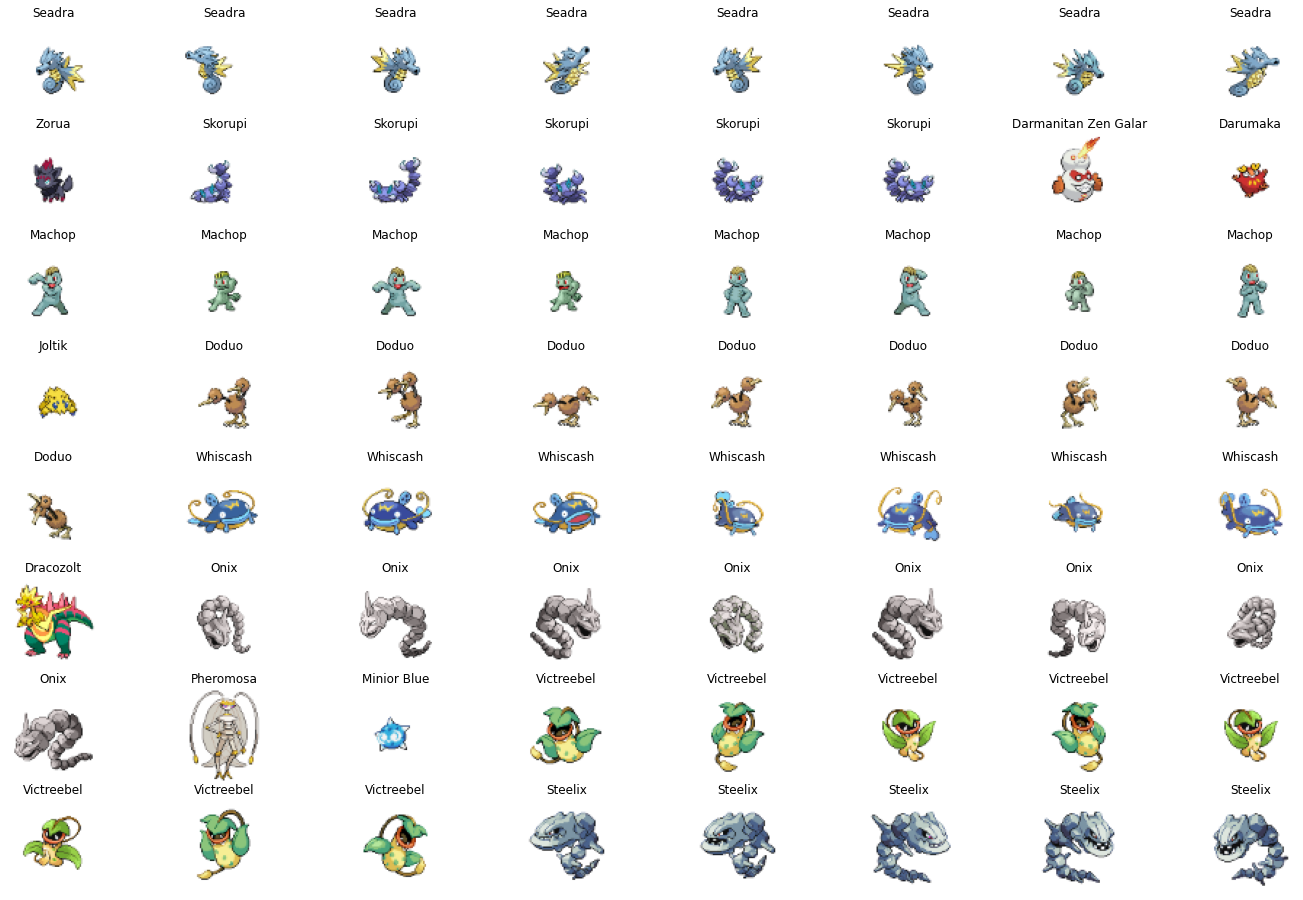

In [15]:
make_images_grid(dataset.images,dataset.pkmn)

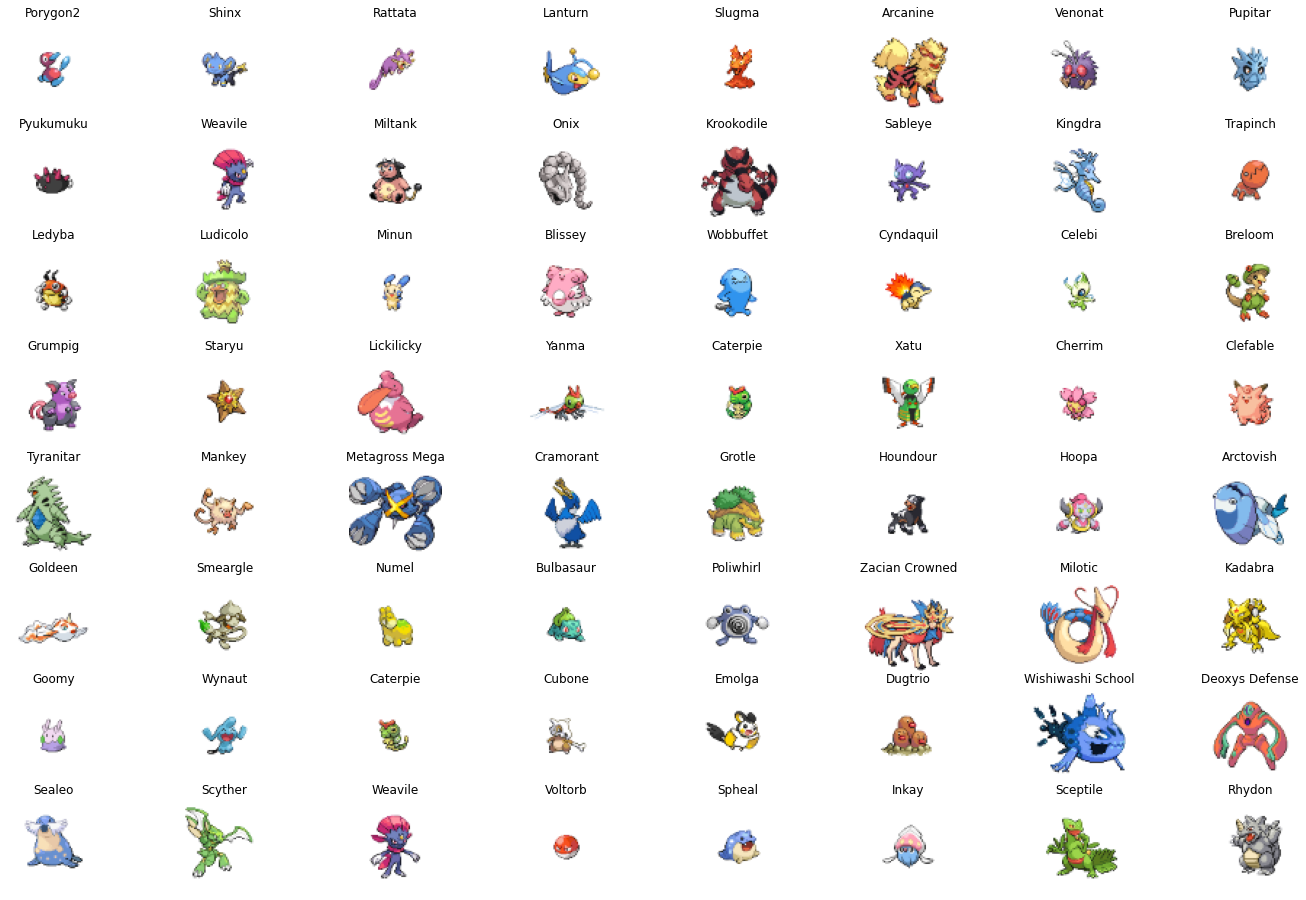

In [17]:
dataloader_example = DataLoader(dataset, batch_size=64, shuffle=True)
example_images, example_labels = next(iter(dataloader_example))
make_images_grid(example_images, example_labels)


In [475]:
ImageDataSet=dataset.images
PokemonDataLoader=DataLoader(ImageDataSet, batch_size=64, shuffle=True)

In [313]:
#Generar modelo Generador de Pokemon Falsos

class Generator(nn.Module):
   def __init__ (self,seed_size):
     super(Generator, self).__init__()
     self.main=nn.Sequential(
     #Input seed_size x 1 x 1
     nn.ConvTranspose2d(seed_size, 32, kernel_size=4, padding=0, stride=1, bias=False),
     nn.BatchNorm2d(32),
     nn.ReLU(True),

     nn.ConvTranspose2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 128, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(128),
     nn.ReLU(True),

     nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
     nn.Tanh()
     )

   def forward(self, input):
        return self.main(input)
      # Output: 3 x 64 x 64

In [376]:
seed_size=100
batch_size=64
generator=Generator(seed_size)
seed_batch = torch.randn(batch_size, seed_size, 1, 1)
fake_pokemon=generator(seed_batch)
row=2
col=2

In [315]:
#Visualizar data
fake_pokemon_np=fake_pokemon.detach().numpy()
fr=fake_pokemon_np.reshape(64,64,3,batch_size)

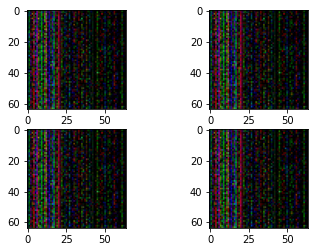

In [316]:
fig, axs = plt.subplots(row,col,figsize=(row * 3, col * 2))
for n in range(batch_size):
    for i in range(row):
            for j in range(col):
              #Ver imagenes en rgb eliminar 1 y colocar :
              axs[i][j].imshow(fr[:, :, :, n])


In [317]:
#Generar modelo Discriminador
class Discriminator(nn.Module):
  def __init__(self,optimizerD):
    super(Discriminator,self). __init__()
    self.dis= nn.Sequential(
        #3 x 64 x 64
        nn.Conv2d(3, 64, kernel_size= 4,stride= 2,padding= 1, bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        #64 x 32 x 32
        nn.Conv2d(64, 128, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        #128x16x16
        nn.Conv2d(128, 256, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        #128x8x8
        nn.Conv2d(256,512, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(512, 1,kernel_size= 4, stride= 1, padding= 0, bias=False),
        nn.Sigmoid()
        )
  def forward(self, input):
        return self.dis(input)

In [375]:
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
discriminator=Discriminator(optimizerD)
print(discriminator.children)

<bound method Module.children of Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )


In [360]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [361]:
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
#Parte Falsa
decision=discriminator(fake_pokemon)
print(decision)

In [ ]:
#Parte Real
decision=discriminator(example_images)
print(decision)

In [301]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [396]:
def trainDiscriminator(real_pokemon,optimizerD,seed_size,batch_size=64):
    
    #Parte Real
    optimizerD.zero_grad()
    real_predictions=discriminator(real_pokemon) 
    real_predictions=real_predictions.cuda()
    label = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 #Generamos etiquetas para la parte real
    label=label.unsqueeze(1) #Reshape labels
    label=label.unsqueeze(1) #Reshape labels
    real_loss = criterion(real_predictions, label)
    #real_loss.backward(retain_graph=True)
    real_score = real_predictions.mean().item()
    #Parte falsa
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(seed_batch)
    gen_predictions = discriminator(fake_pokemon).cuda()
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 #Generamos etiquetas para la parte falsa
    gen_targets=gen_targets.unsqueeze(1) #Reshape labels
    gen_targets=gen_targets.unsqueeze(1) #Reshape labels
    gen_loss= criterion(gen_predictions,gen_targets)
    gen_score = torch.mean(gen_predictions).item()

    total_loss = real_loss + gen_loss
    total_loss.backward()
    optimizerD.step()
    return total_loss.item(), real_score, gen_score

In [412]:
def trainGenerator(optimizerG,seed_size,batch_size=64):
  optimizerG.zero_grad()
#Entrenamiento del Generador para mejorar Parte falsa
  latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
  fake_pokemon = generator(seed_batch)
  disc_predictions = discriminator(fake_pokemon).cuda()
  targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
  targets= targets.unsqueeze(1)
  targets= targets.unsqueeze(1)
  loss = criterion(disc_predictions, targets)
  loss.backward()
  optimizerG.step()
  return loss.item()

In [511]:
def trainGAN(num_epoch,seed_size,batch_size=64,beta1=0.5,learning_rate=0.0002,idx=1,):
  torch.cuda.empty_cache() #Ahorramos memoria cuda
   # Track losses and scores
  criterion = nn.BCELoss()
  disc_losses = []
  disc_scores = []
  gen_losses = []
  gen_scores = []

  optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
  optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
  print("Entrenando...")
  for epoch in range(num_epoch):  
   for real_pokemon, data in tqdm(Dev_Loader, 0):
     disc_loss, real_score, gen_score =trainDiscriminator(real_pokemon,optimizerD,seed_size,batch_size)
     gen_loss = trainGenerator(optimizerG,seed_size)

   disc_losses.append(disc_loss)
   disc_scores.append(real_score)
   gen_losses.append(gen_loss)
   gen_scores.append(gen_score)
   print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
epoch+idx, num_epoch, gen_loss, disc_loss, real_score, gen_score))
   
  return disc_losses, disc_scores, gen_losses, gen_scores

In [505]:
#Adaptado de https://github.com/jkleiber/PokeGAN/blob/master/PokeGAN.ipynb
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [493]:
from numpy.ma.core import transpose
#Cambiamos el nombre por una columna con 1 para pasar a GPU
d_labels=[1*(dataset.images.shape[0])]
d_labels=np.ones(d_labels)
d_labels=transpose(d_labels)
dataset.pkmn=d_labels
PokemonDataLoader=DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [513]:
#Pasar DataLoader a GPU/CPU
Dev_Loader=DeviceDataLoader(PokemonDataLoader,device)

In [517]:
#Pasamos la semilla del batch a GPU
seed_batch=to_device(seed_batch,device)

In [514]:
#Pasamos todo a un mismo entorno
to_device(generator,device)
to_device(discriminator,device)


Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [518]:
#Test de 1 epoca de entrenamiento en GPU, Bajo de 3min a 6 seg amonos 
trainGAN(1,seed_size=256)

Entrenando...


  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/1], gen_loss: 1.9774, disc_loss: 0.9170, real_score: 0.2898, gen_score: 0.6176


([0.9169788956642151],
 [0.289762407541275],
 [1.977374792098999],
 [0.6175759434700012])

Falta Recuperar la imagen una vez procesada por el GPU

In [1]:
latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
fake_pokemon = generator(seed_batch)
fake_pokemon_np=fake_pokemon.cpu().detach().numpy()
fr=fake_pokemon_np.reshape(64,64,3,batch_size)

NameError: ignored

Ejemplo tras una epoca de entrenamiento en CPU, se me acabo de vuelta la GPU xD podemos observar como cambio el fondo a pixeles blancos y comienza a generar pixeles de colores por el centro va por buen camino

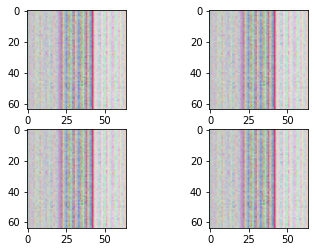

In [422]:
fig, axs = plt.subplots(row,col,figsize=(row * 3, col * 2))
for n in range(batch_size):
    for i in range(row):
            for j in range(col):
              #Ver imagenes en rgb eliminar 1 y colocar :
              axs[i][j].imshow(fr[:, :, :, n])

Bibliografia, les recomiendo checarla porque se utilizó

https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images

https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb

https://www.tensorflow.org/tutorials/generative/dcgan

https://github.com/jkleiber/PokeGAN/blob/master/PokeGAN.ipynb
